## CNN Modeling of CMB Foregrounds
The goal of this project is to use a Convolutional Neural Network (CNN) to predict the foreground contamination of a Cosmic Microwave Background (CMB) map. The training data will use an all-sky map created using the Python Sky Model (PySM3) with dust and synchrotron contamination for the inputs, and an all-sky projection with no contamination for the targets. The images in the training dataset will be generated by using Healpix to generate square images at random points on the sky.  

# Set Device

In [14]:
COLAB_FOLDER = 'ML' # change as needed
GITHUB_USER  = 'hbprosper'
GITHUB_REPO  = 'mlinphysics'
GITHUB_FOLDERS = ['mlinphysics']
#------------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    print('\nGoogle Drive mounted\n')
    IN_COLAB = True
except:
    print('\nRunning locally\n')
    IN_COLAB = False

if IN_COLAB:
    MYDRIVE     = '/content/gdrive/MyDrive'
    GITHUB_BASE = 'https://raw.githubusercontent.com'
    MAIN        = 'refs/heads/main'
    GITHUB_PATH = f'{MYDRIVE}/{COLAB_FOLDER}'
    #------------------------------------------------------
    %cd {GITHUB_PATH}
    %rm -f {GITHUB_PATH}/clone2colab.ipynb
    !wget -q {GITHUB_BASE}/{GITHUB_USER}/{GITHUB_REPO}/{MAIN}/clone2colab.ipynb
    %run {GITHUB_PATH}/clone2colab.ipynb
    %cd /content/gdrive/MyDrive/ML/Foregrounds/
    !pip install visualtorch
    !pip install pysm3
    !pip install healpy

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Google Drive mounted

/content/gdrive/MyDrive/ML
/content
	1. uninstall mlinphysics
	2. sparse clone mlinphysics

/content/mlinphysics

	3. install mlinphysics

/content
/content/gdrive/MyDrive/ML/Foregrounds


# Image Creation
The CNN will be trained on square images of all sky projections from the Python Sky Model. These images will have 3 input channels: the contaminated CMB map, the latitude map, and the longitude map. The maps will be square and uniform in size, with the size and resolution being specified by the user in the make_images function. The make_foreground_maps function generates the actual all-sky projections. Each of these function only need to be run once, the results are saved to H5 files. Thus, after these files exist, the user can comment out the functions below.

In [15]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np
import h5py
import matplotlib.pyplot as plt
import warnings
import torch

warnings.filterwarnings("ignore")

#function to write the all sky maps with and without contaminants to fits file
def make_foreground_maps(frequencies, strings, nside):
    sky = pysm3.Sky(nside = nside, preset_strings=strings + ["c1"])
    sky_true = pysm3.Sky(nside = nside, preset_strings = ["c1"])
    for frequency in frequencies:
        skymap = sky.get_emission(frequency*u.GHz)
        skymap = skymap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency*u.GHz))
        skymap_true = sky_true.get_emission(frequency*u.GHz)
        skymap_true = skymap_true.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(frequency*u.GHz))
        hp.fitsfunc.write_map(str(frequency) + "GHz", skymap, overwrite=True)
        hp.fitsfunc.write_map(str(frequency) + "GHz_true", skymap_true, overwrite=True)

#function to write all sky lat/lon maps to fits file
def make_angle_maps(nside):
    npix = hp.nside2npix(nside)
    arr = np.arange(npix)
    m = hp.pixelfunc.pix2ang(nside,arr)
    hp.fitsfunc.write_map(str(nside) + "_lat", m[0], overwrite=True)
    hp.fitsfunc.write_map(str(nside) + "_lon", m[1], overwrite=True)


def make_images(num, res):
    #This function randomly selects a patch on the sky to create images for model.
    #Generate the CMB image and the lat/lon images on the sky
    #num is the number of images
    #res is the resolution of the image in arcminutes

    #loading all sky projections
    map_100 = hp.fitsfunc.read_map("100GHz", field = (0,1,2))
    map_100_true = hp.fitsfunc.read_map("100GHz_true", field = (0,1,2))
    lat_map = hp.fitsfunc.read_map("512_lat", field = 0)
    lon_map = hp.fitsfunc.read_map("512_lon", field = 0)


    size = 128
    image_arr = np.zeros((num, 4, size, size))

    for i in range(num):
        #random generation of lat lon angles on sky
        print("generating image " + str(i))
        lon = np.random.random() * 360
        lat = np.random.random() * 180 - 90


        #generate Q map for both contaminated and uncontaminated skies
        Q_100_square = hp.gnomview(map_100[1], rot = [lon, lat], reso = res, xsize = size, return_projected_map=True, no_plot=True)
        plt.close('all')
        Q_100_true = hp.gnomview(map_100_true[1], rot = [lon, lat], reso = res, xsize = size, return_projected_map=True, no_plot=True)

        #generate lat/lon maps
        lon_square = hp.gnomview(lon_map, rot=[lon,lat], reso=res, xsize=size, return_projected_map=True, no_plot=True)
        lat_square = hp.gnomview(lat_map, rot=[lon,lat], reso=res, xsize=size, return_projected_map=True, no_plot=True)

        #stack the maps into one 3D array along first axis
        image_arr[i] = np.stack((Q_100_square, Q_100_true, lat_square, lon_square))

    #save array to h5 file
    with h5py.File('images.h5', 'w') as hf:
        hf.create_dataset('foregrounds_images', data = image_arr)

#generate all sky projections and cuts. This only has to be done once, then can be commented out unless new foreground contaminants or cuts are desired.
#make_foreground_maps([100,217,353], ["s1", "d1"], 512)
#make_angle_maps(512)
#make_images(2000, 4)

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\n\tAvailable device: {str(DEVICE):4s}\n')


	Available device: cuda



# Convolutional Neural Network Layout
The input shape of the image fed to the network is (3,size,size). The three channels of the input are the contaminated map, the latitude map, and the longitude map. The output of the model will also have size (3, size, size) with the same layout. The size variable denotes the dimension of the map in pixels.

# Define Model

In [17]:
import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat
import mlinphysics.utils.monitor as mon

#load images

with h5py.File("images.h5", "r") as f:
    images = f['foregrounds_images']
    images = images[...]

#configure model

    name = 'foregrounds'

    load_existing_config = False

    if load_existing_config:
        config = mlp.Config(f'{name}.yaml')
    else:
        config = mlp.Config(name)

        #training config
        n_images = 2000
        batch_size = 16
        n_iters_per_epoch = 24
        train_size = n_iters_per_epoch * batch_size
        test_size = 25
        val_size = n_images - train_size - test_size

        config('batch_size', batch_size)
        config('train_size', train_size)
        config('test_size', test_size)
        config('val_size', val_size)

        config('monitor_step', 10)
        config('delete', True)
        config('frac', 0.015)

        #optimizer/scheduler

        config('n_epochs', 4000)
        config('n_iters_per_epoch', n_iters_per_epoch)
        config('n_iterations', config('n_epochs') * config('n_iters_per_epoch'))
        config('n_steps', 4)
        config('n_iters_per_step', config('n_iterations') // config('n_steps'))
        config('base_lr', 1.e-3)
        config('gamma', 0.8)

        config.save()
    print(config)


    #

    print(train_size, test_size, val_size)

name: foregrounds
file:
  losses: runs/2025-12-02_1425/foregrounds_losses.csv
  params: runs/2025-12-02_1425/foregrounds_params.pth
  init_params: runs/2025-12-02_1425/foregrounds_init_params.pth
  plots: runs/2025-12-02_1425/foregrounds_plots.png
batch_size: 16
train_size: 384
test_size: 25
val_size: 1591
monitor_step: 10
delete: true
frac: 0.015
n_epochs: 4000
n_iters_per_epoch: 24
n_iterations: 96000
n_steps: 4
n_iters_per_step: 24000
base_lr: 0.001
gamma: 0.8

384 25 1591


# Prepare Data
The position maps (latitude and longitude) should be appended to both the inputs and the targets so that the model can compared where it thinks it map is on the sky to where it actually is. The CMB map will also be normalized so that the data is in the range (0,1). The position maps will not be normalized.

In [18]:
print(images.shape)

ims = images[:,0:1,:,:].astype(np.float32)
targs = images[:,1:2,:,:].astype(np.float32)
latlon = images[:,2:, :, :].astype(np.float32)


#scale data
ims_scale = np.max(ims) - np.min(ims)
ims = (ims - np.min(ims)) / ims_scale
targs_scale = np.max(targs) - np.min(targs)
targs = (targs - np.min(targs)) / targs_scale

latlon_1_scale = np.max(latlon[:,0,:,:]) - np.min(latlon[:,0,:,:])
latlon_2_scale = np.max(latlon[:,1,:,:]) - np.min(latlon[:,1,:,:])

latlon[:,0,:,:] = (latlon[:,0,:,:] - np.min(latlon[:,0,:,:])) / latlon_1_scale
latlon[:,1,:,:] = (latlon[:,1,:,:] - np.min(latlon[:,1,:,:])) / latlon_2_scale

#lat and lon maps get put on both the targets and the inputs
ims = np.concatenate((ims,latlon), axis = 1)
targs = np.concatenate((targs, latlon), axis = 1)

(2000, 4, 128, 128)


In [19]:
import importlib
importlib.reload(dat)

train_size = config('train_size')
val_size = config('val_size')
test_size = config('test_size')

#define datasets
print('training data')
train_data = dat.Dataset(ims, start=0, end=train_size,targets=targs,verbose=True)

print('training data for validation')
train_data_val = dat.Dataset(ims, start=0, end=train_size, targets=targs, random_sample_size=val_size)

print('validation data')
val_data = dat.Dataset(ims, start=train_size, end=train_size+val_size, targets=targs)

print('test data')
test_data = dat.Dataset(ims, start = train_size + val_size, end=train_size + val_size + test_size, targets=targs)

training data
Dataset
  shape of x: torch.Size([384, 3, 128, 128])
  shape of y: torch.Size([384, 3, 128, 128])

training data for validation
Dataset
  shape of x: torch.Size([1591, 3, 128, 128])
  shape of y: torch.Size([1591, 3, 128, 128])

validation data
Dataset
  shape of x: torch.Size([1591, 3, 128, 128])
  shape of y: torch.Size([1591, 3, 128, 128])

test data
Dataset
  shape of x: torch.Size([25, 3, 128, 128])
  shape of y: torch.Size([25, 3, 128, 128])



# DataLoaders

In [20]:
import torch.utils.data as dt
print('train data loader')
train_loader = dt.DataLoader(train_data,
                             batch_size=config('batch_size'),
                             shuffle=True)

print('train data loader for validation')
train_loader_val = dt.DataLoader(train_data_val,
                                 batch_size=len(train_data_val))

print('validation data loader')
val_loader  = dt.DataLoader(val_data,
                            batch_size=len(val_data))

print('test data loader')
test_loader = dt.DataLoader(test_data,
                            batch_size=len(test_data))

train data loader
train data loader for validation
validation data loader
test data loader


# Build Model

In [21]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding = 1, dropout = 0.04):
        super().__init__()
        kernel_size = 2*padding + 1 #3x3 for all convolutions for now
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size=kernel_size, stride=1, padding = padding, padding_mode='circular')
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        #currently not doing any downsampling

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class DilConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation = 2, padding = 1, dropout = 0.04):
        super().__init__()
        kernel_size = 2*padding + 1
        self.dconv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = 1, padding = padding, dilation = dilation, padding_mode = 'circular')
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dconv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class ForegroundCleaner(mlp.Model):
    def __init__(self, image_size=128, channels=(3,9,14,9,3), padding = 1):
        super().__init__()

        nlayers = len(channels) - 1


        layers = [ConvBlock(channels[i], channels[i+1], padding) for i in range(nlayers)]

        #no additional layers for now as the final layer is a convolution
        #first set of layers with only convolution blocks
        self.layers1 = nn.ModuleList(layers)

        #second set of layers which will include dilated convolution
        layers2 = []

        #alternate between convolution and dilated convolution blocks
        for i in range(nlayers):
            if i % 2 == 0:
                layers2.append(DilConvBlock(channels[i], channels[i+1], 1))
            else:
                layers2.append(ConvBlock(channels[i], channels[i+1]))

        self.layers2 = nn.ModuleList(layers2)

        #third set of layers which takes the input maps, downsamples, and passes through convolution
        #the goal is to emphasize the large scale structure

        layers3 = []

        layers3.append(nn.AvgPool2d(kernel_size=4)) #4x4 kernel size in the downsampling
        layers3.append(ConvBlock(3,6))
        layers3.append(ConvBlock(6,9))
        layers3.append(ConvBlock(9,6))
        layers3.append(ConvBlock(6,3))
        layers3.append(nn.Upsample(scale_factor=4, mode='nearest'))

        self.layers3 = nn.ModuleList(layers3)

        #The final convolution block to convolute the output from each of the branches
        self.final_layer = nn.Conv2d(in_channels=9, out_channels=3, kernel_size=3, padding=1, stride=1, padding_mode='circular')

    def forward(self,x):
        x1 = x
        x2 = x
        x3 = x
        for layer in self.layers1:
            x1 = layer(x1)
        for layer in self.layers2:
            x2 = layer(x2)
        for layer in self.layers3:
            x3 = layer(x3)
        #concatenate together the results from each branch
        x = torch.cat((x1, x2, x3), dim = 1)
        #and now pass through colvolution
        x = self.final_layer(x)
        return x


# Instantiate Model

In [22]:
importlib.reload(mlp)

model = ForegroundCleaner().to(DEVICE)
print(model)
print()

print('number of parameters', mlp.number_of_parameters(model))
print()

ForegroundCleaner(
  (layers1): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(9, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(14, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (batchnorm): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.04, inplace=False)
    )
    (3): ConvBlock(
      (conv): Conv2d(9, 3, kernel_size=(3, 3), stri

# Loss Function
The loss function will have 3 parts, and will be of the form:
$$L = \alpha{L_1} + \beta{L_2} + \gamma{L_3}$$
The first term will compare the output map to the input map directly. It will use the mean absolute error, or L1 loss function between the output map and the target map:
$$L_1 = \frac{1}{N}\sum_{n=0}^{N-1}(\frac{1}{XY}\sum_{i=0}^{X-1}\sum_{j=0}^{Y-1}|y^n_{ij} - y'^{n}_{ij}|)$$
Where $N$ is the batch size, $X$ is the image size in the x direction, and $Y$ is the image size in the y direction. $y$ is the output map and $y'$ is the target map.
The second term is also a L1 loss function, but it will compare the difference between the maps in Fourier space:
$$L_2 = \frac{1}{N}\sum_{n=0}^{N-1}(\frac{1}{XY}\sum_{i = 0}^{X-1}\sum_{j=0}^{Y-1}|A(\tilde{y})^n_{ij} - A(\tilde{y}')^n_{ij}|)$$
Where $\tilde{y}$ the Fourier transform of the input map and $\tilde{y}'$ is the Fourier transform of the target map. The $A()$ function represents taking the amplitude of the Fourier Transform.
The last term will be the quadratic loss between the position maps:
$$
L_3 = \frac{1}{N}\sum_{n=0}^{N-1}(\frac{1}{2XY}\sum_{i=0}^{X - 1}\sum_{j=0}^{Y-1}\sum_{k=0}^{1}(y^n_{ijk} - y'^n_{ijk})^2)
$$  

Here the index $k$ indicates whether the latitude or longitude map is being used. The terms are then summed together and as previously mention will be of the form:
$$
L = \alpha{L_1} + \beta{L_2} + \gamma{L_3}
$$
Where $\alpha$, $\beta$, and $\gamma$ are constants set such that each term has the same order magnitude impact on the overall loss function, to avoid one term being overemphasized.

In [23]:
import math
import sys
class LossFunction():

    def __init__(self):
        pass

    def __call__(self, outputs, targets):
        #outputs is the maps coming out of the final convolution block, shape (batch_size, 3, size, size)
        #targets is the same as before, the maps with no foreground contaminants (batch_size, 3, size, size)
        #3 terms summed together give the loss function

        #First term: The mean absolute difference between the output map and the target map
        #sum across image in batch, image pixels, and across frequency using only I maps for now

        #Take the means of the absolute difference across a single image in x and y (exclude lat and lon channels)
        #if the mean absolute difference of position channels is used, the whol outputs and targets just get included here
        #and the L_3 term can be commented out.
        #L_1 = torch.mean(torch.abs(outputs[:,:1,:,:] - targets[:,:1,:,:]) / torch.max(torch.abs(outputs[:,:1,:,:] - targets[:,:1,:,:])))
        L_1 = torch.mean(torch.abs(outputs[:,:1,:,:] - targets[:,:1,:,:]))

        #Second term: The mean absolute difference between the amplitudes of the Fourier transforms of the output and target maps
        #First get the amplitudes of the Fourier transforms

        L_2_arr = np.zeros((len(outputs[:,0,0,0]), len(outputs[0,:,0,0]))) #Fill as we go

        for i in range(len(outputs[:,0,0,0])): #loop over batch size
            for j in range(len(outputs[0,:,0,0]) - 2): #loop over frequencies (exclude the position channels)
                #Take the 2D FFT of both the outputs and targets
                FFT_output = torch.fft.fft2(outputs[i,j,:,:])
                FFT_target = torch.fft.fft2(targets[i,j,:,:])
                #Get the amplitudes of the FFTs
                A_output = torch.sqrt(FFT_output.real**2 + FFT_output.imag**2)
                A_target = torch.sqrt(FFT_target.real**2 + FFT_target.imag**2)
                #Get the mean of the absolute value difference of the amplitudes across each FFT map
                #ans = torch.mean(torch.abs(A_output - A_target) / torch.max(torch.abs(A_target - A_output)))
                ans = torch.mean(torch.abs(A_output - A_target))
                #Assign to appropriate place in array
                L_2_arr[i,j] = ans
        #Now do the average across batch size
        L_2 = np.mean(L_2_arr)

        #Third term: The mean square difference between the position maps. The aim is to make the model reconstruct the position maps on the sky
        #so that the model "knows" where it is on the sky.
        #average over x and y the square difference in lat and lon
        #L_3 = torch.mean((outputs[:,1:,:,:] - targets[:,1:,:,:])**2 / torch.max((outputs[:,1:,:,:] - targets[:,1:,:,:])**2))
        L_3 = torch.mean((outputs[:,1:,:,:] - targets[:,1:,:,:])**2)

        #coefficients in final loss function were determined by trial and error until each term was
        #approximately the same, so that each term has equal weight in the final loss function
        alpha = 1
        beta = 1/20
        gamma = 2

        L = alpha*L_1 + beta*L_2 + gamma*L_3


        return L

# Instatiate Training Objects

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=config('base_lr'))
scheduler = mlp.get_steplr_scheduler(optimizer, config)
objective = mlp.Objective(model, LossFunction())

number of milestones:          3

Step | Milestone | LR
-----------------------------
   0 |         0 | 1.0e-03   
-----------------------------
   1 |     24000 | 8.0e-04   
   2 |     48000 | 6.4e-04   
   3 |     72000 | 5.1e-04   

number of iterations:          96000



# Define Trainer

In [25]:
def train(objective, optimizer, scheduler,
          train_loader, train_small_loader, val_loader,
          config):

    # get configuration info
    lossfile   = config('file/losses')
    paramsfile = config('file/params')
    step       = config('monitor_step')
    delete     = config('delete')
    frac       = config('frac')
    nepochs    = config('n_epochs')
    niters     = config('n_iterations')

    # instantiate object that saves average losses to
    # a csv file for realtime monitoring

    losswriter = mon.LossWriter(niters,
                                lossfile,
                                step=step,
                                delete=delete,
                                frac=frac,
                                model=objective.model,
                                paramsfile=paramsfile)

    # instantiate learning rate step scheduler
    lrscheduler = mlp.LRStepScheduler(optimizer, scheduler)

    # -----------------------------
    # training loop
    # -----------------------------
    ii = -1
    for epoch in range(nepochs):

        for x, y in train_loader:

            ii += 1

            # set mode to training so that training-specific
            # operations such as dropout, etc., are enabled.
            objective.train()

            # clear all gradients
            optimizer.zero_grad()

            # compute empirical risk
            R = objective(x, y)

            # compute gradients
            R.backward()

            # take one step downhill in the empirical risk landscape
            optimizer.step()

            # check whether to update learning rate
            lrscheduler.step()

            # I'm alive printout
            if (ii % step == 0) or (ii == niters-1):
                with torch.no_grad(): #the no_grad is here to save memory, otherwise I was running out
                    # compute average losses on training and validation data
                    t_loss = mlp.compute_avg_loss(objective, train_small_loader)
                    v_loss = mlp.compute_avg_loss(objective, val_loader)

                # return current learning rate
                lr = lrscheduler.lr()

                # update loss file
                losswriter(ii, t_loss, v_loss, lr, epoch)

In [30]:
importlib.reload(mlp)
importlib.reload(mon)
import matplotlib.pyplot as plt
#train(objective, optimizer, scheduler, train_loader, train_loader_val, val_loader, config)

#monitor = mon.Monitor(config('file/losses'))
#monitor.plot()

# Visualization of Testing Results
Make plots to visualize the results of the model. The current plot contains 4 seperate plots: the contaminated input map, the output CMB map from the model, the actual CMB map generated without any contaminants, and a 2d histogram of the actual map values vs. the predicted map values. The histogram should ideally be the same, and fall along a straight line with slope 1.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
torch.Size([25, 3, 128, 128])
RMS Error Original Maps  tensor(0.3401, device='cuda:0')
RMS Error Cleaned Maps  tensor(0.0243, device='cuda:0', grad_fn=<SqrtBackward0>)


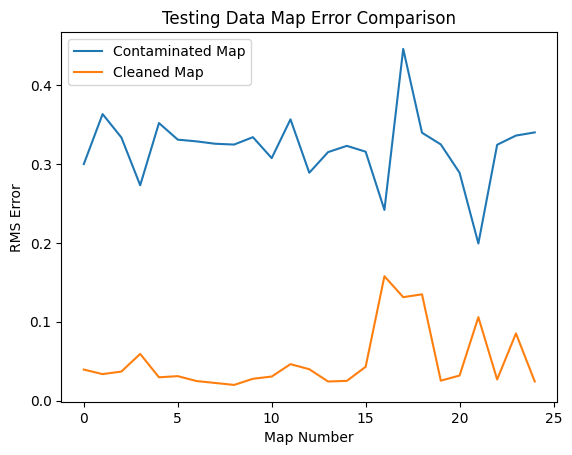

In [34]:
#plot the validation output map alongside the true output map
from mpl_toolkits.axes_grid1 import make_axes_locatable
#model.load(config('file/params'))
model.load("runs/2025-11-25_1625/foregrounds_params.pth")
test_x, test_y = next(iter(test_loader))
y_pred = model(test_x)
input_rms = []
output_rms = []
for i in range(test_size):
    index = 0 #Set this to 0 for polarization plot, 1 for lat, 2 for lon
    plot_test_y = test_y[i,index,:,:]
    plot_pred_y = y_pred[i,index,:,:]
    plot_in_map = test_x[i,index,:,:]

    fig, ax = plt.subplots(2,2,figsize=(12,6))

    im0 = ax[0,0].imshow(plot_pred_y.cpu().detach().numpy(), vmin = torch.min(plot_test_y), vmax = torch.max(plot_test_y))
    ax[0,0].set_title("Predicted Output")

    im1 = ax[0,1].imshow(plot_test_y.cpu().detach().numpy(), vmin = torch.min(plot_test_y), vmax = torch.max(plot_test_y))
    ax[0,1].set_title("Actual Output")

    im2 = ax[1,0].imshow(plot_pred_y.cpu().detach().numpy() - plot_test_y.cpu().detach().numpy(), vmin = torch.min((plot_pred_y - plot_test_y)), vmax = torch.max(plot_pred_y - plot_test_y))
    ax[1,0].set_title("Diff")

    divider0 = make_axes_locatable(ax[0,0])
    cax = divider0.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(im1, cax = cax)

    divider1 = make_axes_locatable(ax[0,1])
    cax = divider1.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(im1, cax = cax)

    divider2 = make_axes_locatable(ax[1,0])
    cax = divider2.append_axes('right', size = '5%', pad = 0.05)
    fig.colorbar(im2, cax = cax)

    #The last plot is a histogram of the predicted map vs the actual map
    #Ideally, the plot should line up along a line with the slope m = 1

    hist, x_edge, y_edge = np.histogram2d(plot_test_y.cpu().detach().numpy().flatten(), plot_pred_y.cpu().detach().numpy().flatten(),bins = 1000)
    #set empty bins to nan so they show up white
    hist[hist == 0] = np.nan
    #overplot a line with slope 1
    x = np.arange(0, len(plot_test_y.cpu().detach().numpy().flatten()))
    y = x
    ax[1,1].plot(x,y)
    ax[1,1].imshow(hist, origin='lower')
    if index == 0:
        fig.suptitle("comp_" + str(i) + " Polarization")
    if index == 1:
        fig.suptitle("comp_" + str(i) + " Latitude")
    if index == 2:
        fig.suptitle("comp_" + str(i) + " Longitude")
    plt.savefig("comp_" + str(i) + ".png")
    plt.close('all')
    input_rms.append(torch.sqrt(torch.mean(((plot_in_map - plot_test_y)/plot_test_y)**2)).cpu().detach())
    output_rms.append(torch.sqrt(torch.mean(((plot_pred_y - plot_test_y)/plot_test_y)**2)).cpu().detach())



In [ ]:
import visualtorch

#plot visualization of layers in model
print(test_x.shape)
test_x = test_x.to(DEVICE)
model.cpu()
img = visualtorch.layered.layered_view(model, input_shape=(3,3,128,128), draw_volume=False, legend=True)
plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.savefig("model.png", dpi = 1000)
plt.close('all')

In [ ]:
#plot rms error of contaminated and cleaned maps
plt.plot(input_rms, label="Contaminated Map")
plt.plot(output_rms, label="Cleaned Map")
plt.xlabel("Map Number")
plt.ylabel("RMS Error")
plt.title("Testing Data Map Error Comparison")
plt.legend()
plt.savefig("RMS_error.png")

print("RMS Error Original Maps ", torch.sqrt(torch.mean(((plot_in_map - plot_test_y)/plot_test_y)**2)))
print("RMS Error Cleaned Maps ", torch.sqrt(torch.mean(((plot_pred_y - plot_test_y)/plot_test_y)**2)))